In [1]:
import tensorflow as tf
import keras
from keras.datasets import fashion_mnist, mnist
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Model
import cv2, numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape, "y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape, "y_test shape:", y_test.shape)

x_train shape: (48000, 28, 28) y_train shape: (48000,)
x_val shape: (12000, 28, 28) y_val shape: (12000,)
x_test shape: (10000, 28, 28) y_test shape: (10000,)


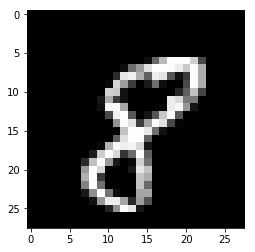

In [3]:
# Show one of the images from the training dataset
plt.imshow(x_train[6], cmap='gray')

# Preprocess data

In [19]:
# Initiate the train and test generators with data Augumentation 
#train_datagen = ImageDataGenerator(
#rescale = 1./255,
#target_size = (56,56))

#train_generator = train_datagen.flow_from_directory(
#train_data_dir,
#target_size = (img_height, img_width),
#batch_size = batch_size, 
#class_mode = "categorical")

In [4]:
# Preprocess dataset
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [5]:
# Enlarge image to fit in VGG16
#im = cv2.resize(cv2.imread('cat.jpg'), (224, 224)).astype(np.float32)

x_train = x_train.repeat(2, axis=1).repeat(2, axis=2)
x_val = x_val.repeat(2, axis=1).repeat(2, axis=2)
x_test = x_test.repeat(2, axis=1).repeat(2, axis=2)

In [6]:
# Reshape to 3-channel
x_train = np.stack((x_train,)*3, -1)
x_val = np.stack((x_val,)*3, -1)
x_test = np.stack((x_test,)*3, -1)

In [7]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(48000, 56, 56, 3)
(12000, 56, 56, 3)
(10000, 56, 56, 3)


In [8]:
# Reformat y in one hot endoded
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_val = keras.utils.to_categorical(y_val, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# Model

In [9]:
x_train.shape[1:]

(56, 56, 3)

In [40]:
model_vgg = keras.applications.vgg16.VGG16(
    include_top=False,
    weights=None, 
    input_tensor=None, 
    input_shape=x_train.shape[1:], 
    pooling=None,
    classes=10)

In [41]:
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
#for layer in model_vgg.layers[:5]:
#    layer.trainable = False

In [42]:
#Adding custom Layers 
model_step2 = model_vgg.output
model_step2 = Flatten(name='flatten')(model_step2)
model_step2 = Dense(100, activation='relu', name='fc1')(model_step2)
model_step2 = Dropout(0.5)(model_step2)
model_step2 = Dense(100, activation='relu', name='fc2')(model_step2)
model_step2 = Dense(10, activation='softmax', name='predictions')(model_step2)

model_merged = Model(model_vgg.input, model_step2)

In [43]:
model_merged.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.1),
              metrics=['accuracy'])

In [44]:
print(x_train.shape)
print(y_train.shape)

(48000, 56, 56, 3)
(48000, 10)


In [45]:
# Define callbacks
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# tensorboard --logdir path_to_current_dir/Graph

In [46]:
model_merged.fit(x_train,
         y_train,
         batch_size=512,
         epochs=1000,
         validation_data=(x_val, y_val),
         callbacks=[checkpoint, early, tbCallBack])

Train on 48000 samples, validate on 12000 samples
Epoch 1/1000
48000/48000 [==============================] - 67s 1ms/step - loss: 14.3996 - acc: 0.0983 - val_loss: 14.5372 - val_acc: 0.0981
Epoch 2/1000
48000/48000 [==============================] - 67s 1ms/step - loss: 14.5261 - acc: 0.0988 - val_loss: 14.5372 - val_acc: 0.0981
Epoch 3/1000
48000/48000 [==============================] - 66s 1ms/step - loss: 14.5261 - acc: 0.0988 - val_loss: 14.5372 - val_acc: 0.0981
Epoch 4/1000
48000/48000 [==============================] - 66s 1ms/step - loss: 14.5261 - acc: 0.0988 - val_loss: 14.5372 - val_acc: 0.0981
Epoch 5/1000
48000/48000 [==============================] - 67s 1ms/step - loss: 14.5261 - acc: 0.0988 - val_loss: 14.5372 - val_acc: 0.0981
Epoch 6/1000
48000/48000 [==============================] - 66s 1ms/step - loss: 14.5261 - acc: 0.0988 - val_loss: 14.5372 - val_acc: 0.0981
Epoch 7/1000
48000/48000 [==============================] - 66s 1ms/step - loss: 14.5261 - acc: 0.0988 -

In [38]:
# Evaluate the model on test set
score = model_merged.evaluate(x_test, y_test, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9895


In [39]:
x_test.shape

(10000, 56, 56, 3)

In [40]:
y_predicted = model_merged.predict(x_test)
for i in range(len(x_test)):
    print("Y=%s, Predicted=%s" % (np.argmax(y_test[i]), np.argmax(y_predicted[i])))
#plt.imshow(test[])

Y=7, Predicted=7
Y=2, Predicted=2
Y=1, Predicted=1
Y=0, Predicted=0
Y=4, Predicted=4
Y=1, Predicted=1
Y=4, Predicted=4
Y=9, Predicted=9
Y=5, Predicted=5
Y=9, Predicted=9
Y=0, Predicted=0
Y=6, Predicted=6
Y=9, Predicted=9
Y=0, Predicted=0
Y=1, Predicted=1
Y=5, Predicted=5
Y=9, Predicted=9
Y=7, Predicted=7
Y=3, Predicted=3
Y=4, Predicted=4
Y=9, Predicted=9
Y=6, Predicted=6
Y=6, Predicted=6
Y=5, Predicted=5
Y=4, Predicted=4
Y=0, Predicted=0
Y=7, Predicted=7
Y=4, Predicted=4
Y=0, Predicted=0
Y=1, Predicted=1
Y=3, Predicted=3
Y=1, Predicted=1
Y=3, Predicted=3
Y=4, Predicted=4
Y=7, Predicted=7
Y=2, Predicted=2
Y=7, Predicted=7
Y=1, Predicted=1
Y=2, Predicted=2
Y=1, Predicted=1
Y=1, Predicted=1
Y=7, Predicted=7
Y=4, Predicted=4
Y=2, Predicted=2
Y=3, Predicted=3
Y=5, Predicted=5
Y=1, Predicted=1
Y=2, Predicted=2
Y=4, Predicted=4
Y=4, Predicted=4
Y=6, Predicted=6
Y=3, Predicted=3
Y=5, Predicted=5
Y=5, Predicted=5
Y=6, Predicted=6
Y=0, Predicted=0
Y=4, Predicted=4
Y=1, Predicted=1
Y=9, Predicted

Y=6, Predicted=6
Y=3, Predicted=3
Y=5, Predicted=5
Y=0, Predicted=0
Y=2, Predicted=2
Y=0, Predicted=0
Y=9, Predicted=9
Y=0, Predicted=0
Y=7, Predicted=7
Y=4, Predicted=4
Y=6, Predicted=6
Y=9, Predicted=9
Y=3, Predicted=3
Y=5, Predicted=5
Y=1, Predicted=1
Y=9, Predicted=9
Y=6, Predicted=6
Y=1, Predicted=1
Y=4, Predicted=4
Y=5, Predicted=5
Y=4, Predicted=4
Y=5, Predicted=5
Y=0, Predicted=0
Y=5, Predicted=5
Y=9, Predicted=9
Y=5, Predicted=5
Y=2, Predicted=2
Y=1, Predicted=1
Y=2, Predicted=2
Y=9, Predicted=9
Y=1, Predicted=1
Y=9, Predicted=9
Y=9, Predicted=9
Y=4, Predicted=4
Y=0, Predicted=0
Y=8, Predicted=8
Y=4, Predicted=4
Y=5, Predicted=5
Y=2, Predicted=2
Y=9, Predicted=9
Y=2, Predicted=2
Y=1, Predicted=1
Y=2, Predicted=2
Y=1, Predicted=1
Y=7, Predicted=7
Y=3, Predicted=3
Y=6, Predicted=6
Y=8, Predicted=8
Y=8, Predicted=8
Y=4, Predicted=4
Y=9, Predicted=9
Y=1, Predicted=1
Y=9, Predicted=9
Y=8, Predicted=8
Y=5, Predicted=5
Y=7, Predicted=7
Y=5, Predicted=5
Y=1, Predicted=1
Y=1, Predicted

Y=4, Predicted=4
Y=4, Predicted=4
Y=4, Predicted=4
Y=4, Predicted=4
Y=7, Predicted=7
Y=1, Predicted=1
Y=6, Predicted=6
Y=2, Predicted=2
Y=9, Predicted=9
Y=9, Predicted=9
Y=0, Predicted=0
Y=0, Predicted=0
Y=1, Predicted=1
Y=8, Predicted=8
Y=8, Predicted=8
Y=4, Predicted=4
Y=3, Predicted=3
Y=4, Predicted=4
Y=2, Predicted=2
Y=0, Predicted=0
Y=6, Predicted=6
Y=1, Predicted=1
Y=6, Predicted=6
Y=1, Predicted=1
Y=2, Predicted=2
Y=2, Predicted=2
Y=2, Predicted=2
Y=1, Predicted=1
Y=2, Predicted=2
Y=3, Predicted=3
Y=7, Predicted=7
Y=8, Predicted=8
Y=1, Predicted=1
Y=0, Predicted=0
Y=0, Predicted=0
Y=2, Predicted=2
Y=1, Predicted=1
Y=6, Predicted=6
Y=6, Predicted=6
Y=0, Predicted=0
Y=1, Predicted=1
Y=6, Predicted=6
Y=2, Predicted=2
Y=5, Predicted=5
Y=1, Predicted=1
Y=7, Predicted=7
Y=4, Predicted=4
Y=8, Predicted=8
Y=2, Predicted=2
Y=1, Predicted=1
Y=4, Predicted=4
Y=3, Predicted=3
Y=8, Predicted=8
Y=3, Predicted=3
Y=9, Predicted=9
Y=9, Predicted=9
Y=4, Predicted=9
Y=8, Predicted=8
Y=3, Predicted

Y=1, Predicted=1
Y=3, Predicted=3
Y=7, Predicted=7
Y=9, Predicted=9
Y=0, Predicted=0
Y=1, Predicted=1
Y=1, Predicted=1
Y=4, Predicted=9
Y=7, Predicted=7
Y=0, Predicted=0
Y=8, Predicted=8
Y=1, Predicted=1
Y=7, Predicted=7
Y=4, Predicted=4
Y=5, Predicted=5
Y=7, Predicted=7
Y=1, Predicted=1
Y=2, Predicted=2
Y=1, Predicted=1
Y=1, Predicted=1
Y=3, Predicted=3
Y=9, Predicted=0
Y=6, Predicted=6
Y=2, Predicted=2
Y=1, Predicted=1
Y=2, Predicted=2
Y=8, Predicted=8
Y=0, Predicted=0
Y=7, Predicted=7
Y=6, Predicted=6
Y=6, Predicted=6
Y=9, Predicted=9
Y=3, Predicted=3
Y=7, Predicted=7
Y=0, Predicted=0
Y=5, Predicted=5
Y=2, Predicted=2
Y=8, Predicted=8
Y=0, Predicted=0
Y=5, Predicted=5
Y=4, Predicted=4
Y=3, Predicted=3
Y=8, Predicted=8
Y=4, Predicted=4
Y=6, Predicted=6
Y=6, Predicted=6
Y=2, Predicted=2
Y=7, Predicted=7
Y=9, Predicted=9
Y=5, Predicted=5
Y=1, Predicted=1
Y=3, Predicted=3
Y=2, Predicted=2
Y=4, Predicted=4
Y=3, Predicted=3
Y=6, Predicted=6
Y=1, Predicted=1
Y=9, Predicted=9
Y=4, Predicted

Y=3, Predicted=3
Y=7, Predicted=1
Y=7, Predicted=7
Y=8, Predicted=8
Y=4, Predicted=4
Y=0, Predicted=0
Y=2, Predicted=2
Y=4, Predicted=4
Y=0, Predicted=0
Y=2, Predicted=2
Y=4, Predicted=4
Y=7, Predicted=7
Y=8, Predicted=8
Y=0, Predicted=0
Y=7, Predicted=7
Y=0, Predicted=0
Y=6, Predicted=6
Y=9, Predicted=9
Y=3, Predicted=3
Y=2, Predicted=2
Y=8, Predicted=8
Y=6, Predicted=6
Y=0, Predicted=7
Y=5, Predicted=5
Y=7, Predicted=7
Y=5, Predicted=5
Y=1, Predicted=1
Y=0, Predicted=0
Y=8, Predicted=8
Y=1, Predicted=1
Y=6, Predicted=6
Y=7, Predicted=7
Y=2, Predicted=2
Y=9, Predicted=9
Y=7, Predicted=7
Y=9, Predicted=9
Y=5, Predicted=5
Y=8, Predicted=8
Y=6, Predicted=6
Y=2, Predicted=2
Y=6, Predicted=6
Y=2, Predicted=2
Y=8, Predicted=8
Y=1, Predicted=1
Y=7, Predicted=7
Y=5, Predicted=5
Y=0, Predicted=0
Y=1, Predicted=1
Y=1, Predicted=1
Y=3, Predicted=3
Y=8, Predicted=1
Y=4, Predicted=4
Y=9, Predicted=9
Y=1, Predicted=1
Y=8, Predicted=8
Y=6, Predicted=6
Y=8, Predicted=8
Y=9, Predicted=9
Y=0, Predicted

Y=0, Predicted=0
Y=2, Predicted=2
Y=3, Predicted=3
Y=4, Predicted=4
Y=3, Predicted=3
Y=8, Predicted=8
Y=5, Predicted=5
Y=1, Predicted=1
Y=5, Predicted=5
Y=2, Predicted=2
Y=3, Predicted=3
Y=0, Predicted=0
Y=1, Predicted=1
Y=2, Predicted=2
Y=1, Predicted=1
Y=3, Predicted=3
Y=2, Predicted=2
Y=6, Predicted=6
Y=5, Predicted=5
Y=3, Predicted=3
Y=0, Predicted=0
Y=7, Predicted=7
Y=2, Predicted=2
Y=7, Predicted=7
Y=4, Predicted=4
Y=6, Predicted=6
Y=4, Predicted=4
Y=0, Predicted=0
Y=5, Predicted=5
Y=9, Predicted=9
Y=9, Predicted=9
Y=8, Predicted=8
Y=9, Predicted=9
Y=5, Predicted=5
Y=3, Predicted=3
Y=1, Predicted=1
Y=7, Predicted=7
Y=4, Predicted=4
Y=7, Predicted=7
Y=6, Predicted=6
Y=5, Predicted=5
Y=4, Predicted=4
Y=0, Predicted=0
Y=0, Predicted=0
Y=6, Predicted=6
Y=6, Predicted=6
Y=2, Predicted=2
Y=0, Predicted=0
Y=6, Predicted=6
Y=3, Predicted=3
Y=7, Predicted=7
Y=7, Predicted=7
Y=4, Predicted=4
Y=4, Predicted=4
Y=3, Predicted=3
Y=9, Predicted=9
Y=2, Predicted=2
Y=8, Predicted=8
Y=9, Predicted

Y=4, Predicted=4
Y=7, Predicted=7
Y=0, Predicted=0
Y=1, Predicted=1
Y=9, Predicted=9
Y=2, Predicted=2
Y=8, Predicted=8
Y=7, Predicted=7
Y=8, Predicted=8
Y=2, Predicted=2
Y=6, Predicted=6
Y=0, Predicted=0
Y=6, Predicted=6
Y=5, Predicted=5
Y=3, Predicted=3
Y=3, Predicted=3
Y=3, Predicted=3
Y=9, Predicted=9
Y=1, Predicted=1
Y=4, Predicted=4
Y=0, Predicted=0
Y=6, Predicted=6
Y=1, Predicted=1
Y=0, Predicted=0
Y=0, Predicted=0
Y=6, Predicted=6
Y=2, Predicted=2
Y=1, Predicted=1
Y=1, Predicted=1
Y=7, Predicted=7
Y=7, Predicted=7
Y=8, Predicted=8
Y=4, Predicted=4
Y=6, Predicted=6
Y=0, Predicted=0
Y=7, Predicted=7
Y=0, Predicted=0
Y=3, Predicted=3
Y=6, Predicted=6
Y=8, Predicted=8
Y=7, Predicted=7
Y=1, Predicted=1
Y=5, Predicted=5
Y=2, Predicted=2
Y=4, Predicted=4
Y=9, Predicted=9
Y=4, Predicted=4
Y=3, Predicted=3
Y=6, Predicted=6
Y=4, Predicted=4
Y=1, Predicted=1
Y=7, Predicted=7
Y=2, Predicted=2
Y=6, Predicted=6
Y=5, Predicted=5
Y=0, Predicted=0
Y=1, Predicted=1
Y=2, Predicted=2
Y=3, Predicted